
---
# Unit03: Processing passive seismic data

This notebook has some practical processing activities of the Course **ProSeisSN**. It deals with time series processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***


# ==> My memos from Volcanoseismology <== to be deleted!

- lecture_14_theory_fourier.ipynb

- lecture_15_theory_filter.ipynb

- lecture_16_theory_spectral_analysis_preprocessing.ipynb

- lecture_18_obspy_signal_processing.ipynb

- Crash course Python com Colab. Use for programing. Do not include obspy.


In [1]:
#------ Import External Libraries
import numpy as np

%matplotlib inline
%matplotlib widget

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
# Change the defaults of the runtime configuration settings in the global variable matplotlib.rcParams
plt.rcParams['figure.figsize'] = 9, 5
#plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams["figure.subplot.hspace"] = (.9)

plt.style.use('ggplot')

#------ Import specialized ObsPy packages + sanity.
try:
    import obspy
    print('obspy version ==>', obspy.__version__)
except TypeError:
    print('Stopping RUNTIME. ObsPy not found.')
    exit()

from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from obspy import read, Stream
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException
from obspy.signal.invsim import cosine_taper

#------ Local routines.
import plot as p


obspy version==> 1.2.2


---
## Accessing data

We work with data form an event occured in Acre in 2024,

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

As recorded at station IU HKT, distant $44^{\circ}$ from the event. We have two options:

- **Read** the data locally $\Longrightarrow$ skip next code, or

- **Retrive** the data from client **IRIS** $\Longrightarrow$ run next code skipping the next one.

---
## Only run the $\Downarrow$ next $\Downarrow$ code to retrieve the data from Iris. Otherwise SKIP IT!

In [ ]:
"""
=========== RETRIEVE THE DATA FROM IRIS =========== 
"""
# Specify event's start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print(starttime, endtime)

# Use wildcards to select all three HH* channels
net = "IU"
sta = "HKT"
loc = "00"
chan = "HH*"

# Specify client. Opt:from obspy.clients.earthworm import Client
# Get waveforms with instrument response into a stream
# List of ObsPy clients: clients = ["IRIS", "NCEDC", "USGS", "GEONET", "RESIF", "INGV", "BGR", "ODC", "SCEDC"]
try:
  client = Client("IRIS")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
except FDSNException:
  print(f"Chosen client is not working.")
  from obspy.clients.earthworm import Client
  client = Client("ETH")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

# Remove the instrument response in all the 3 components/traces.
st.remove_response(output = 'VEL')

---
## Alternatively run the code  $\Downarrow$ below $\Downarrow$ to read the data locally.

In [4]:
"""
=========== READ THE DATA LOCALLY ===========
"""
# Read the data into a stream object
st = read('wb11793085r.msd')
print(f"Stream of Acre event at station IU HKT:\n {st}")

Stream of Acre event at station IU HKT:
 3 Trace(s) in Stream:
IU.HKT.00.HH1 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:14.538394Z | 100.0 Hz, 41552 samples
IU.HKT.00.HH2 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.648394Z | 100.0 Hz, 41863 samples
IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples


---
## WARNINGS:
#### 1) Always press the ***stop interation button *** before running another plotting cell!  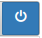
#### 2) Use plot $\Downarrow$ BELOW $\Downarrow$ to decide on trimming limits!

Characteristis for the Z-component:
          network: IU
         station: HKT
        location: 00
         channel: HHZ
       starttime: 2024-01-20T21:36:19.028394Z
         endtime: 2024-01-20T21:43:17.688394Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 41867
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 748, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 1145856})


<IPython.core.display.Javascript object>


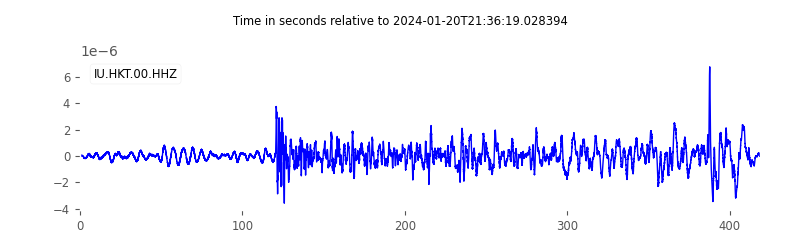

IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples

In [5]:
# Print stream information and plot the z-component
print(f"Characteristis for the Z-component:\n {st[-1].stats}")

# Make a deep copy of the Z-component
trZ = st[-1].copy()

# Plot the z-component
#                     +──+─> x-axis in duration (s)                           
trZ.plot(color='blue', type='relative', handle=True)
#                                      +────+─> Returns a matplotlib figure instance 

trZ

---
## Data Trimming

Remove time segments of the signal.   

Original trace has a duration of 418.66s
Enter a window [t[0] t[1]]s on the trace duration to trim the trace
 Enter t[0] and t[1] (rtn= the whole trace):
40 380


<IPython.core.display.Javascript object>


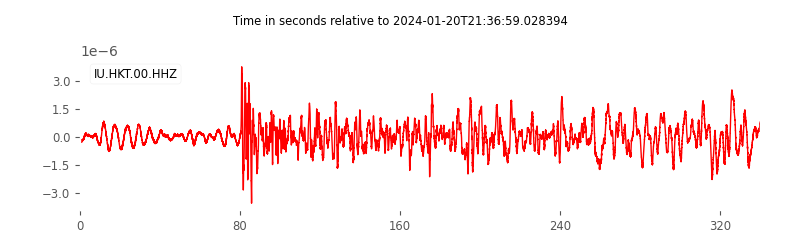

IU.HKT.00.HHZ | 2024-01-20T21:36:59.028394Z - 2024-01-20T21:42:39.028394Z | 100.0 Hz, 34001 samples

In [6]:
print(f"Original trace has a duration of {trZ.stats.endtime - trZ.stats.starttime}s")
print(f"Enter a window [t[0] t[1]]s on the trace duration to trim the trace")

ent = input(f' Enter t[0] and t[1] (rtn= the whole trace):\n') or False
 
#      +───────────────────────────────────────────────+─> string lists <─+─────────────────────+
ent = ['0', str(trZ.stats.endtime - trZ.stats.starttime)] if not ent else ent.rstrip().split(' ')
# Transforms a str list into an ARRAY OF FLOATS
ent = np.array(ent, dtype=float)

# TRIM trace now ==> NB: trace is modifyed in place!!!
trZ.trim(trZ.stats.starttime + ent[0], trZ.stats.starttime + ent[-1])

#Plot
trZ.plot(color='red', type='relative', handle=True)

trZ

---

## Preprocessing data

**Preprocessing data** is done before any attempt toward any scientific analysis. The needed steps include:

- Detrend and demean the data
- Window the data
- Instrument correction   
- Low-pass filtering
- Downsample or resample the data
- Select a specific window and Pad it with zeros
- Ohter filtering stages.

### The Fourier transform

A great deal of the work is done in the frequency domain where we can analyse the signal according with its energy content by frequency, or its spectral energy contents. The **Fourier transform** is given by
$$
F(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt \leftrightarrow f(t) =  \int_{-\infty}^{\infty} F(\omega)e^{i\omega t}dt
$$
in its integral form (NB: *the signal on the exponent is a matter of convention*). 

In seismics the signals are discrete in time, so we turn to the *discrete form*,
$$
F_k = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2\pi i k j /N} \leftrightarrow f_k = \sum_{j=0}^{N-1} F_j e^{2\pi i k j /N}
$$
where
- $j$ corresponds to a time sample $\,\rightarrow\:f_j\,\in\mathbb{R}$, is the signal at the corresponding time $j$
- $N$ is the number of time samples $\,\rightarrow\:j=1,\ldots,N$
- $k$ corresponds to a frequency value $\,\rightarrow\:F_j\,\in\mathbb{C}$, is the **amplitude** at the corresponding frequency $k$.

#### Brute force frequency content
Investigate the frequency content of the amplitude spectrum, $\in\mathbb{R}$, using *brute force*. This results in a poor spectrum with energy leakage and numerical instabilities. We need to do a better job.

z-component has 34001 at 0.01s, with a time-window 340.0s


<IPython.core.display.Javascript object>


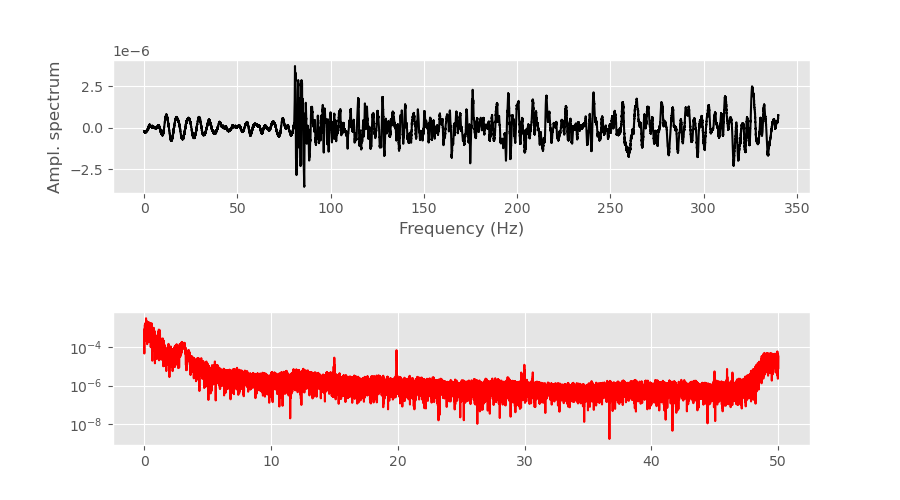

In [7]:
#--- z-component characteristics
npts = trZ.stats.npts                           # number of samples
dt   = trZ.stats.delta                          # sampling interval
fNy  = 1. / (2.0 * dt)                          # Nyquist frequency
time = trZ.times(type="relative")               # nummpy array with reative time t=0,...
lsec = time[-1]                                 # length of signal in seconds

# Print stream information and plot the 
print(f"z-component has {npts} at {dt}s, with a time-window {lsec}s")

# Frequency domain +───────+─> trace data as a nummpy array
FtrZ = np.fft.rfft(trZ.data)

#--- frequency axis for plotting
# frequency values         +───────+─> length of FT of the signal
freq = np.linspace(0, fNy, len(FtrZ))

#Plot
p.pltTrSp(time, trZ.data, freq, abs(FtrZ),
        x1label='Time (s)', y1label='Amplitude',
        x2label='Frequency (Hz)', y2label='Ampl. spectrum', y2log=True
        )

---
## Demean / detrend
If the trace has a mean $\overline{\textrm{trace}}\neq0$ or if it has a trend, most spectral enegy will
$\underset{\omega\rightarrow0}{\mathcal{E}}\!\!\!\rightarrow\infty$. Look the above spectrum.
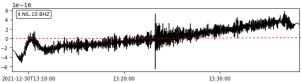

- Subtract a LS (least squares) from the data.
- Subtract the mean of the data

#### The code $\Downarrow$ BELOW $\Downarrow$ will change the trace *in place*; do not run it twice!

<IPython.core.display.Javascript object>


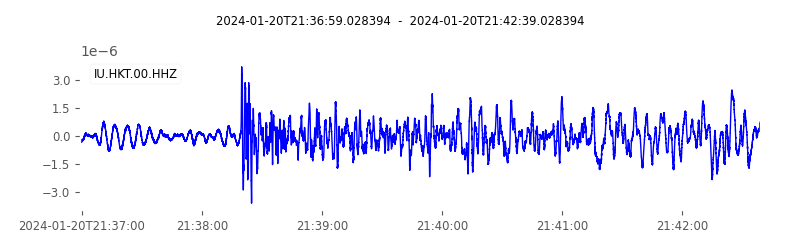

<IPython.core.display.Javascript object>


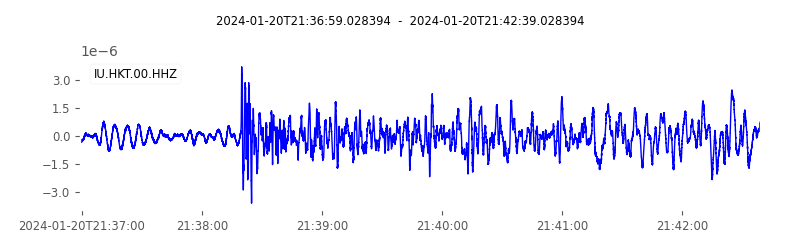

In [31]:
#safety copy
tr = trZ.copy()
# Remove any linear trend
tr.detrend("linear")
# Remove the mean
tr.detrend("demean")

ent = input(f' Enter t[0] and t[1] (rtn= the whole trace):\n') or False


#Plot
trZ.plot(color='blue')

## Filtering

Let $x\left(t\right)\rightarrow X\left(\omega\right)$ be a Fourier pair. The application of a filter on $x\left(t\right)$ produce another Fourier pair
$$\mathcal{F}\left\{ x\left(t\right)\right\} =y\left(t\right)\rightarrow Y\left(\omega\right)$$

The filter **frequency response function** is given by its ***transfer function*** (Fourier transform of the **output signal** divided by the Fourier transformation of the **input signal**.)

$$ T(\omega) = \frac{Y(\omega)}{X(\omega)}$$,

The transfer function of a simple lowpass filter is

$$ |T(\omega)| = \sqrt{ \frac{1}{1+(\frac{\omega}{\omega_c})^{2n}} } $$

where:
- $\omega$ is the frequency;
- $\omega_c$ is the corner frequency;
- $n$ is the filter order, or its number of corners. It defines the slope steepness of the **transition band**, the higher it is, the steeper is the slope. 
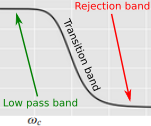

Filters can be
| **causal** |  $\Vert$ | **acausal** |
| :-: | :-: | :-: |
| Not symmetric | $\Vert$ |Symmetric |
| O/P depends on past & present of the I/P | $\Vert$ | O/P depends on past, present and future of the I/P |

- A non-causal filter without real-time future values can be achied with forward-backward filtering, where the signal is also filtered in the reverse direction in time, effectively canceling out the phase delay introduced by the forward **causal** filter.

#### Four main types of filters:
- **lowpass filter**, where the pass-band is $\omega\lessapprox\omega_{c}$
- **highpass filter**, where the pass-band is $\omega\gtrapprox\omega_{c}$
- **bandpass filter**, where the pass-band is $\omega\gtrapprox\omega_{c}\lessapprox\omega$
- **bandstop filter**, where the pass-band is $\omega\lessapprox\omega_{c}\gtrapprox\omega$

Those four filters are easily implemented in the **frequency domain**: (i) transform the signal via **FFT**; (ii) multiply it with the **FFT of the impulse response function**; and (iii) transfer the result back to the **time-domain**.

There are filters which are often implemented in the **time-domain**:
- **Infinite impulse response (IIR) filters**, which are recursive & causal, are more efficient in terms of the number of coefficients required for a sharp bandpass response but may introduce phase distortion.

- **Finite impulse response (FIR) filters**, which are non-recursive & causal or acausal, can provide a linear-phase response, which avoids phase distortion, but they may require more coefficients to achieve the same level of sharpness in the frequency response as an IIR filter.

---
### Lowpass filter the signal

In [26]:
print(f"Enter the corner frequency and filter order: f0, Nc,")
print(f" if just one I/P then Nc = 4")
ent = input(f' Enter f0 and Nc (dflt: Nc=4)\n')
#
ent = ent.rstrip().split(' ')
#      +──────────────+─>       lists!       <─+────────────────────────+
ent = [float(ent[0]), 4] if len(ent) == 1 else [float(ent[0]), int(ent[1])]









Enter the corner frequency and filter order: f0, Nc,
 if just one I/P then Nc = 4
 Enter f0 and Nc (dflt: Nc=4)
10
1 [10.0, 4]
